# Value Function Iteration with GPUArray.jl

The usage of the GPU for numerical computations in numerical tasks that are common for the applied (macro)economist can be extremely beneficial (see _"**Tapping the Supercomputer Under Your Desk: Solving Dynamic Equilibrium Models with Graphics Processors**" by Eric M. Aldrich, Jesús Fernández-Villaverde, A. Ronald Gallant and Juan F. Rubio-Ramírez_), as the time required to run parallel algorithms on the GPU is usually much, much less than that necessary on the CPU.

Using the GPU, and specifically either CUDA or OpenCL, can however be taxing for the general user: the syntax is much less user-friendly than higher-level languages like Matlab, R or Julia, and the time required to set up the algorithm environment is very high. Also, C-like syntax requires the user to deal with the "dirty" details of memory access, usage and management. Errors are hard to debug, and flexibility is hindered.

In Julia, **[OpenCL.jl](https://github.com/JuliaGPU/OpenCL.jl)** provides a direct way to execute an OpenCL kernel on and push/get data from the GPU: however, the OpenCL kernel itself _need to be programmed in OpenCL-C code_. This is a just a basic way of interacting with the GPU, and provides only minimal benefits compared to, say, doing most of the programming directly in C/C++ and OpenCL-C.

However, thanks to the amazing packages **[GPUArrays.jl](https://github.com/JuliaGPU/GPUArrays.jl)** and, in this specific case, **[CLArrays.jl](https://github.com/JuliaGPU/CLArrays.jl)**, it is possible to **program the GPU directly in Julia**!

### Setting up the Model

First, we include the `matrixPrint.jl` file for "pretty" matrix printing:

In [1]:
include("matrixPrint.jl")

matprint (generic function with 1 method)

The very simple problem we are going to solve here is a basic **Real Business Cycle** (**RBC**) model with only capital as the state variable. In recursive form, it can be written as

$ \text{V}(k) \; = \; \underset{k'}{\max} \left\{ \frac{c_t^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}[\text{V}(k')] \right\} \quad \text{s.t.} \quad {k' = k^{\alpha} + (1-\delta)k - c } $

For the **Value Function Iteration** algorithm we are going to use, we need to set:
1. The _lower_ and _upper_ bounds for the capital grid, `lb` and `ub`;
2. The number of grid points;
3. the type of grid points (in this simple case, evenly spaced);
4. Choose parameter values for $\alpha$ and $\beta$;

**NOTE**: 
- For simplicity, $\delta = 1$ is supposed here, because it makes it possibile to derive a closed-form solution of the value function. If $0 < \delta < 1$, then such closed form does not exist.
- The elasticity of substitution is $\sigma = 1$ i.e. we use logarithmic utility.

In [2]:
# Lower bound for the capital grid:
lb = 0.001;
# Upper bound for the capital grid: 
ub = 10;
# Number of grid points:
grid_size = 1000;
# Create an evenly spaced capital grid:
grid_w = Array{Float32}(collect(linspace(lb, ub, grid_size)));

alpha = 0.5;
beta = 0.7;

matprint(grid_w)

Array{Float32,1} showing [1:8/1000, 1:1]
[
	0.001
	0.011
	0.021
	0.031
	0.041
	0.051
	0.061
	0.071063064
	...
];


### (Naive) Value Function Iteration on the CPU

A direct implementation of the **VFI** algorithm is as follows:
1. Start with an initial guess for the Value Function;
2. For each point of the capital grid, use the capital law of motion to compute $c(k,k') = k^{\alpha}-k'$ for every $k'$ on the capital grid;
3. If $log(c) > 0$, then maximize for $k'$ the value of $log(c)+\beta \text{V}(k')$;
4. Repeat from step 1 for `maxiter_` number of times;

In [3]:
function cpu_vfi(grid_::Array{Float32}, alpha::Float64, beta::Float64, maxiter_, prec_)
    
    SIZE_GRID = size(grid_,1);
    
    V = Array{Float32}(ones(SIZE_GRID, 1));

    for it = 1:maxiter_
        
        for i = 1:SIZE_GRID
            tmp = grid_[i].^alpha .- grid_;
            tmp_max = -Inf;
            for (j, point_j) in enumerate(tmp)
                if point_j > 0
                    tmp_comp = log.(point_j) .+ beta.*V[j];
                    tmp_max = max(tmp_comp, tmp_max);
                end
            end
            V[i] = tmp_max;
        end
            
    end
    
    return V
        
end

cpu_vfi (generic function with 1 method)

### Value Function Iteration on the GPU with CLArrays.jl

For the GPU, the process is almost the same, but some care has to be taken.

To begin with, data structures like arrays have to be defined _inside_ the GPU memory, which can be done as follows

`gpu_array = CLArray(Array{Float32}(array))`

where `array` is a previously defined array in Julia. Here, note that we must force the `Float32` variable type: this is because not all GPUs support 64-bit arithmetic, but virtually all modern GPU support 32-bit floating point numbers.

Then, we must ask the GPU to run the VFI algorithm for us. This is done through the following syntax

```
gpu_call(array, (input tuple), [size_of_array]) do state, <input tuple variables>
    ...
    ...
end
```

_E.g_: `gpu_call(A, (A, b)) do state, A, b`

Every kernel run on the GPU is inside a **context** of execution, and to each context the GPU assign a specific index that indicates which data elemnent it is working on. To access this index, the `@linearidx` macro is used in GPUArrays.jl and CLArrays.cl:

```
gpu_call(array, (input tuple), [size_of_array]) do state, <input tuple variables>
    idx = @linearidx array
    ...
end
```

For Value Function Iteration, we can thus write the following code:

In [4]:
using CLArrays, GPUArrays

function gpu_vfi(grid_::Array{Float32}, alpha::Float32, beta::Float32, maxiter_, prec_)
    
    SIZE_GRID = size(grid_, 1);
    
    V = ones(CLArray{Float32}, SIZE_GRID, 1);
    grid = CLArray(Array{Float32}(grid_));
    
    for iter_ in 1:maxiter_
    
    # Write kernel for GPU manually:
    gpu_call(grid, (grid, V, Float32(alpha), Float32(beta), UInt32(SIZE_GRID))) do state, grid, V, alpha, beta, SIZE_GRID
        idx = @linearidx grid
        tmp_max = Float32(-Inf);
        @inbounds begin
            for i = 1:SIZE_GRID
                tmp_i = log(grid[idx]^alpha - grid[i]) + beta*V[i];
                if tmp_i > tmp_max
                    tmp_max = tmp_i;
                end
            end
            V[idx] = tmp_max;
        end   
        return
    end
        
    end
    
    return Array{Float32}(V)
        
end

gpu_vfi (generic function with 1 method)

### Timing code execution

We now compare CPU and GPU performance for the **first run**.

The CPU, with this small problem, easily beats the GPU in a first run, mainly because the GPU requires data and kernels to be moved into the GPU memory before hand, and there is also some time required to compile the OpenCL code generated.

In [5]:
cpu_time = @elapsed CPU_OUT = cpu_vfi(grid_w, alpha, beta, 100, 0.0001);
matprint(CPU_OUT)

Array{Float32,2} showing [1:8/1000, 1:1]
[
	-8.638
	-6.795
	-6.292
	-5.993
	-5.777
	-5.609
	-5.473
	-5.355224
	...
];


In [7]:
cl_device = CLArrays.devices()[1]
CLArrays.init(cl_device)

OpenCL context with:
CL version: OpenCL 1.2 
Device: CL Intel(R) Iris(TM) Graphics 550
            threads: 256
             blocks: (256, 256, 256)
      global_memory: 1610.612736 mb
 free_global_memory: NaN mb
       local_memory: 0.065536 mb


In [8]:
gpu_time = @elapsed GPU_OUT = gpu_vfi(grid_w, Float32(alpha), Float32(beta), 100, 0.0001)
matprint(GPU_OUT)

Array{Float32,2} showing [1:8/1000, 1:1]
[
	-8.638
	-6.795
	-6.292
	-5.993
	-5.777
	-5.609
	-5.473
	-5.3552237
	...
];


ERROR (unhandled task failure): OpenCL Error: OpenCL.Context error: 
Stacktrace:
 [1] raise_context_error(::String, ::String) at /Users/giovannib/.julia/v0.6/OpenCL/src/context.jl:109
 [2] macro expansion at /Users/giovannib/.julia/v0.6/OpenCL/src/context.jl:148 [inlined]
 [3] (::OpenCL.cl.##43#44)() at ./task.jl:335


In [9]:
using Plots; gr()
Plots.scalefontsizes(1.5)

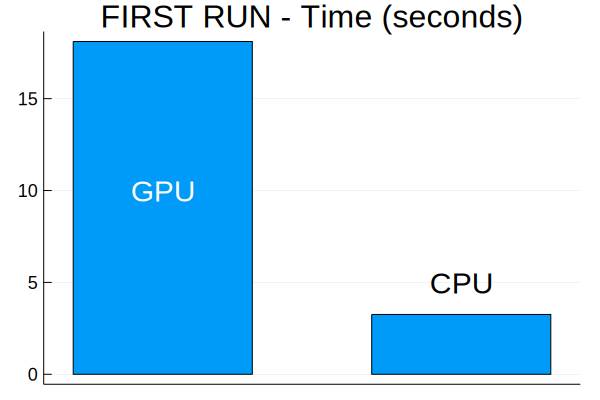

In [12]:
bar([1,2], [gpu_time, cpu_time], xticks=[1, 2], bar_width=0.6, 
        legend=false, title="FIRST RUN  -  Time (seconds)", xticks=[])
annotate!([(1, 10, text("GPU",20,:white,:center)),
          (2, 5, text("CPU",20,:center))])

### GPU vs CPU code perfomance

How fast can the GPU be once it is properly initialized?

Suppose we change the parameters of the RBC model. The CPU remains unchanged, and execution time is not impacted.

On the other hand, the GPU code needs not to be compiled, and most of the data has been (temporarily) moved to the GPU memory. Hence, now the GPU execution is more than **10 times** faster than the CPU counterpart. Unfortunately, some is always spent in moving the result from the GPU memory back to the main memory, so there is still a fixed cost that can not be removed.

However, GPU perfomance is much higher than that of the CPU, and also scales much better as, for example, grid size increases.

In [16]:
cpu_time = @elapsed CPU_OUT = cpu_vfi(grid_w, 0.3, 0.6, 100, 0.0001)
matprint(CPU_OUT)

Array{Float32,2} showing [1:8/1000, 1:1]
[
	-3.966
	-3.088
	-2.851
	-2.708
	-2.606
	-2.526
	-2.461
	-2.4049423
	...
];


In [17]:
gpu_time = @elapsed GPU_OUT = gpu_vfi(grid_w, Float32(0.3), Float32(0.6), 100, 0.0001)
matprint(GPU_OUT)

Array{Float32,2} showing [1:8/1000, 1:1]
[
	-3.966
	-3.088
	-2.851
	-2.708
	-2.606
	-2.526
	-2.461
	-2.4049423
	...
];


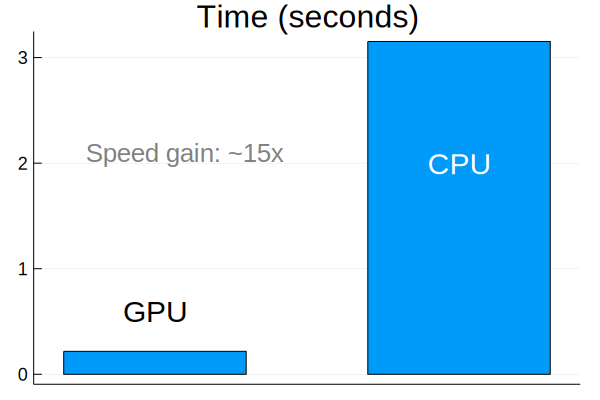

CPU time: 3.152 seconds
GPU time: 0.2174 seconds


In [20]:
println("CPU time: ", Float16(cpu_time), " seconds")
println("GPU time: ", Float16(gpu_time), " seconds")

bar([1,2], [gpu_time, cpu_time], xticks=[1, 2], bar_width=0.6, 
        legend=false, title="Time (seconds)", xticks=[])
annotate!([(1, 0.6, text("GPU",20,:center)),
          (2, 2, text("CPU",20,:white,:center)),
          (1.1, 2.1, text("Speed gain: ~15x",18,:left,:grey,:center))])

We create a much finer grid:

In [21]:
# Number of grid points:
grid_size_fine = 5000;
# Create an evenly spaced capital grid:
grid_w_fine = Array{Float32}(collect(linspace(lb, ub, grid_size_fine)));

In [22]:
cpu_time = @elapsed CPU_OUT = cpu_vfi(grid_w_fine, 0.3, 0.6, 100, 0.0001)
matprint(CPU_OUT)

In [23]:
gpu_time = @elapsed GPU_OUT = gpu_vfi(grid_w_fine, Float32(0.3), Float32(0.6), 100, 0.0001)
matprint(GPU_OUT)

Array{Float32,2} showing [1:8/5000, 1:1]
[
	-3.964
	-3.562
	-3.376
	-3.252
	-3.161
	-3.087
	-3.026
	-2.9736362
	...
];


As we can see, with a grid with 5000 points, the GPU code scales much better, with what is now a perfomance gain of around **100 times** when compared to the CPU.

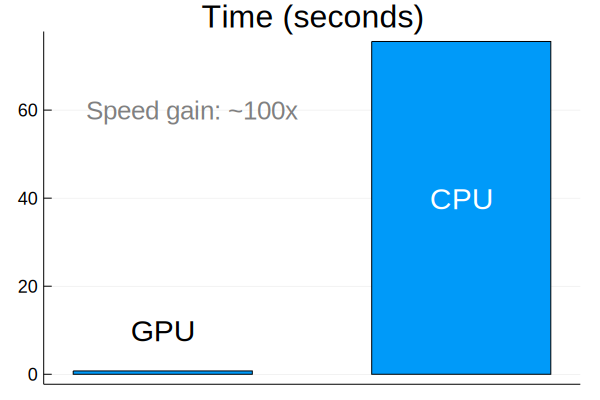

Array{Float32,2} showing [1:8/5000, 1:1]
[
	-3.964
	-3.562
	-3.376
	-3.252
	-3.161
	-3.087
	-3.026
	-2.9736364
	...
];
CPU time: 75.56 seconds
GPU time: 0.755 seconds


In [24]:
println("CPU time: ", Float16(cpu_time), " seconds")
println("GPU time: ", Float16(gpu_time), " seconds")

bar([1,2], [gpu_time, cpu_time], xticks=[1, 2], bar_width=0.6, 
        legend=false, title="Time (seconds)", xticks=[])
annotate!([(1,10, text("GPU",20,:center)),
          (2,40, text("CPU",20,:white,:center)),
          (1.1, 60, text("Speed gain: ~100x",18,:left,:grey,:center))])

### Final notes

- The CPU and GPU codes are far from optimized, and this especially true for the CPU algorithm: we are not taking advantage of the parallel capabilities of Julia, that allow to emply all of the (multiple) cores of modern CPUs;

- The RBC model is simple, and deterministic, so does not represent the real computational needs of modern economic models;

- What happens is we decide to introduce stochastic components? 

- How do these benchmarks scale when the number of variables increases? 